In [1]:
import pandas as pd

C:\Users\zeyuj\AppData\Local\Temp\ipykernel_13888\224983077.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_place(place, tags={'building': True})
c:\Users\zeyuj\anaconda3\envs\ox\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\zeyuj\AppData\Local\Temp\ipykernel_13888\224983077.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(["Streets", "Ca

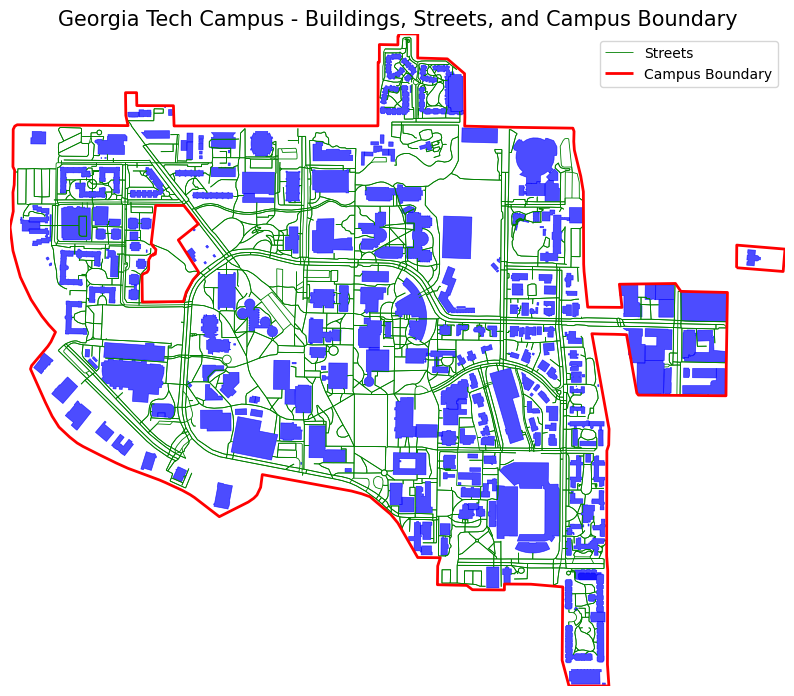

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the location - Georgia Tech, Atlanta, GA
place = "Georgia Institute of Technology, Atlanta, Georgia, USA"

# Download building footprints
buildings = ox.geometries_from_place(place, tags={'building': True})

# Download all streets (includes roads, sidewalks, paths, etc.)
streets = ox.graph_from_place(place, network_type='all')

# Get the campus boundary
campus_boundary = ox.geocode_to_gdf(place)

# Calculate the bounding box based on all geometries
minx, miny, maxx, maxy = campus_boundary.total_bounds

# Plot everything together
fig, ax = plt.subplots(figsize=(10, 10))

# Plot buildings
buildings.plot(ax=ax, color="blue", edgecolor="blue", linewidth=0.5, alpha=0.7, label="Buildings")

# Plot streets
ox.plot_graph(streets, ax=ax, show=False, close=False, edge_color="green", edge_linewidth=0.6, node_size=0)

# Plot the campus boundary
campus_boundary.boundary.plot(ax=ax, color="red", linewidth=2, label="Campus Boundary")

# Set axis limits to the full extent of the campus boundary
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)


# Customize the plot
ax.set_title("Georgia Tech Campus - Buildings, Streets, and Campus Boundary", fontsize=15)
ax.axis("off")
plt.legend(["Streets", "Campus Boundary", "Buildings"], loc="upper right")
plt.show()


In [3]:
"""
Grid Generator - Optimized for Large Areas
Includes density controls and performance optimizations
Modified to show building distances in popups
"""

import osmnx as ox
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
import folium
from tqdm import tqdm

def get_utm_crs(lat: float, lon: float) -> str:
    """Calculate UTM zone for given coordinates."""
    zone_number = int((lon + 180) / 6) + 1
    hemisphere = 'north' if lat >= 0 else 'south'
    epsg = f"326{zone_number:02d}" if hemisphere == 'north' else f"327{zone_number:02d}"
    return f"EPSG:{epsg}"

class OptimizedGridGenerator:
    def __init__(self, 
                 bbox, 
                 spacing_meters=100, 
                 network_type="all_private",
                 max_points=5000):
        """Initialize optimized grid generator."""
        self.bbox = bbox
        self.max_points = max_points
        
        # Create initial GeoDataFrame from bbox
        self.area = gpd.GeoDataFrame(
            geometry=[box(*bbox)],
            crs="EPSG:4326"
        )
        
        # Get UTM zone
        center_lat = (bbox[1] + bbox[3]) / 2
        center_lon = (bbox[0] + bbox[2]) / 2
        self.utm_crs = get_utm_crs(center_lat, center_lon)
        
        print(f"Using UTM zone: {self.utm_crs}")
        
        # Project area to UTM
        self.area_projected = self.area.to_crs(self.utm_crs)
        
        # Calculate appropriate spacing based on area and max points
        self._adjust_spacing(spacing_meters)
        
        # Download street network (optional - can be done later)
        self.network_type = network_type
        self.graph = None
        
        # Generate grid points
        self._generate_points()

    def _adjust_spacing(self, requested_spacing):
        """Adjust spacing to respect max_points limit."""
        bounds = self.area_projected.total_bounds
        area_width = bounds[2] - bounds[0]
        area_height = bounds[3] - bounds[1]
        
        n_cols = int(area_width / requested_spacing) + 1
        n_rows = int(area_height / requested_spacing) + 1
        total_points = n_cols * n_rows
        
        if total_points > self.max_points:
            area = area_width * area_height
            point_density = self.max_points / area
            adjusted_spacing = np.sqrt(1 / point_density)
            print(f"Adjusting spacing from {requested_spacing}m to {adjusted_spacing:.1f}m to limit points")
            self.spacing_meters = adjusted_spacing
        else:
            self.spacing_meters = requested_spacing

    def _generate_points(self):
        """Generate grid points with optimization."""
        bounds = self.area_projected.total_bounds
        
        x = np.arange(bounds[0], bounds[2], self.spacing_meters)
        y = np.arange(bounds[1], bounds[3], self.spacing_meters)
        xx, yy = np.meshgrid(x, y)
        
        points = gpd.GeoDataFrame(
            geometry=[Point(x, y) for x, y in zip(xx.flatten(), yy.flatten())],
            crs=self.area_projected.crs
        )
        
        self.points_gdf = gpd.clip(points, self.area_projected)
        self.points_gdf = self.points_gdf.to_crs("EPSG:4326")
        
        print(f"Generated {len(self.points_gdf)} points with {self.spacing_meters:.1f}m spacing")

    def load_network(self, force_reload=False):
        """Load street network on demand."""
        if self.graph is None or force_reload:
            print("Downloading street network...")
            self.graph = ox.graph_from_bbox(
                north=self.bbox[3], south=self.bbox[1],
                east=self.bbox[2], west=self.bbox[0],
                network_type=self.network_type
            )
            self.graph_projected = ox.project_graph(self.graph, to_crs=self.utm_crs)

    def get_nearest_nodes(self, batch_size=100):
        """Find nearest network nodes in batches."""
        if self.graph is None:
            self.load_network()
        
        print("Finding nearest nodes in batches...")
        nearest_nodes = []
        distances = []
        
        for i in tqdm(range(0, len(self.points_gdf), batch_size)):
            batch = self.points_gdf.iloc[i:i+batch_size]
            nearest = ox.nearest_nodes(
                self.graph,
                X=batch.geometry.x.tolist(),
                Y=batch.geometry.y.tolist(),
                return_dist=True
            )
            nearest_nodes.extend(nearest[0])
            distances.extend(nearest[1])
        
        self.points_gdf['nearest_node'] = nearest_nodes
        self.points_gdf['distance_to_node'] = distances
        return self.points_gdf

    def plot_with_network(self, show_network=True, max_points_to_plot=1000):
        """Create interactive map with enhanced popups including distance information."""
        if show_network and self.graph is None:
            self.load_network()
            
        # Calculate center
        center_lat = (self.bbox[1] + self.bbox[3]) / 2
        center_lon = (self.bbox[0] + self.bbox[2]) / 2
        
        # Create map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=15
        )
        
        # Add boundary
        folium.GeoJson(
            self.area,
            style_function=lambda x: {
                'color': 'red',
                'weight': 2,
                'fillOpacity': 0
            }
        ).add_to(m)
        
        # Add street network
        if show_network and self.graph is not None:
            ox.plot_graph_folium(
                self.graph,
                graph_map=m,
                weight=1,
                color='gray'
            )
        
        # Sample points if there are too many
        points_to_plot = self.points_gdf
        if len(self.points_gdf) > max_points_to_plot:
            print(f"Sampling {max_points_to_plot} points for visualization")
            points_to_plot = points_to_plot.sample(max_points_to_plot)
        
        # Define color function based on building distance
        def get_point_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'  # No building distance data
            elif distance < 10:
                return 'red'
            elif distance < 25:
                return 'orange'
            elif distance < 50:
                return 'yellow'
            else:
                return 'blue'
        
        # Add points with enhanced popups
        for idx, point in points_to_plot.iterrows():
            # Create popup content with distance information
            popup_content = [
                f'<strong>Point ID:</strong> {idx}',
                f'<strong>Coordinates:</strong>',
                f'Lat: {point.geometry.y:.6f}',
                f'Lon: {point.geometry.x:.6f}'
            ]
            
            # Add building distance if available
            building_distance = point.get('distance_to_building', None)
            if building_distance is not None and not np.isnan(building_distance):
                popup_content.append(
                    f'<strong>Distance to nearest building:</strong> {building_distance:.1f}m'
                )
                point_color = get_point_color(building_distance)
            else:
                popup_content.append('<strong>Distance to building:</strong> Not calculated')
                point_color = 'gray'
            
            # Add street distance if available
            street_distance = point.get('distance_to_node', None)
            if street_distance is not None and not np.isnan(street_distance):
                popup_content.append(
                    f'<strong>Distance to nearest street:</strong> {street_distance:.1f}m'
                )
            
            # Add library distance if available
            library_distance = point.get('library', None)
            if library_distance is not None and not np.isnan(library_distance):
                popup_content.append(
                    f'<strong>Distance to nearest library:</strong> {library_distance:.1f}m'
                )

            # Add parking distance if available
            parking_distance = point.get('parking', None)
            if parking_distance is not None and not np.isnan(parking_distance):
                popup_content.append(
                    f'<strong>Distance to nearest parking:</strong> {parking_distance:.1f}m'
                )

            # Add footway distance if available
            footway_distance = point.get('footway', None)
            if footway_distance is not None and not np.isnan(footway_distance):
                popup_content.append(
                    f'<strong>Distance to nearest footway:</strong> {footway_distance:.1f}m'
                )

            # Add grass distance if available
            grass_distance = point.get('grass', None)
            if grass_distance is not None and not np.isnan(grass_distance):
                popup_content.append(
                    f'<strong>Distance to nearest grass:</strong> {grass_distance:.1f}m'
                )

            # Add fitness centre distance if available
            fitness_centre_distance = point.get('fitness_centre', None)
            if fitness_centre_distance is not None and not np.isnan(fitness_centre_distance):
                popup_content.append(
                    f'<strong>Distance to nearest fitness centre:</strong> {fitness_centre_distance:.1f}m'
                )

            # Add wood distance if available
            wood_distance = point.get('wood', None)
            if wood_distance is not None and not np.isnan(wood_distance):
                popup_content.append(
                    f'<strong>Distance to nearest wood:</strong> {wood_distance:.1f}m'
                )

            # Add wetland distance if available
            wetland_distance = point.get('wetland', None)
            if wetland_distance is not None and not np.isnan(wetland_distance):
                popup_content.append(
                    f'<strong>Distance to nearest wetland:</strong> {wetland_distance:.1f}m'
                )

            # Create popup with HTML formatting
            popup_html = '<br>'.join(popup_content)
            
            # Create tooltip with distance info
            if building_distance is not None and not np.isnan(building_distance):
                tooltip = f'Building: {building_distance:.1f}m'
            else:
                tooltip = 'Click for details'
            
            # Add circle marker
            folium.CircleMarker(
                location=[point.geometry.y, point.geometry.x],
                radius=3,
                color=point_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)
        
        # Add a legend
        legend_html = '''
             <div style="position: fixed; 
                         bottom: 50px; right: 50px; width: 170px;
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color:white;
                         padding: 10px;
                         border-radius: 5px;
                         ">
             <p style="margin-bottom: 5px"><strong>Distance to Building</strong></p>
             <p style="margin: 2px;"><span style="color: red;">●</span> < 10m</p>
             <p style="margin: 2px;"><span style="color: orange;">●</span> < 25m</p>
             <p style="margin: 2px;"><span style="color: yellow;">●</span> < 50m</p>
             <p style="margin: 2px;"><span style="color: blue;">●</span> ≥ 50m</p>
             <p style="margin: 2px;"><span style="color: gray;">●</span> No data</p>
             </div>
             '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        return m
    
    def calculate_building_distances(self, buildings_gdf):
        """Calculate distance from each grid point to the nearest building."""
        print("Calculating distances to nearest buildings...")
        
        # Project buildings to same UTM CRS as our grid
        buildings_projected = buildings_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of buildings for faster computation
        from shapely.ops import unary_union
        buildings_union = unary_union(buildings_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(buildings_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_building'] = distances
        print(f"Calculated distances for {len(self.points_gdf)} points")

    def calculate_park_distances(self, parks_gdf):
        """Calculate distance from each grid point to the nearest park."""
        print("Calculating distances to nearest parks...")
        
        # Project parks to same UTM CRS as our grid
        parks_projected = parks_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of parks for faster computation
        from shapely.ops import unary_union
        parks_union = unary_union(parks_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(parks_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_park'] = distances
        print(f"Calculated park distances for {len(self.points_gdf)} points")

    def calculate_library_distances(self, library_gdf):
        """Calculate distance from each grid point to the nearest library."""
        print("Calculating distances to nearest library...")
        
        # Project parks to same UTM CRS as our grid
        library_projected = library_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of parks for faster computation
        from shapely.ops import unary_union
        library_union = unary_union(library_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(library_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_library'] = distances
        print(f"Calculated library distances for {len(self.points_gdf)} points")

    def calculate_college_distances(self, college_gdf):
        """Calculate distance from each grid point to the nearest college."""
        print("Calculating distances to nearest college...")
        
        # Project colleges to same UTM CRS as our grid
        college_projected = college_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of colleges for faster computation
        from shapely.ops import unary_union
        college_union = unary_union(college_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(college_union))
            distances.extend(batch_distances)
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_college'] = distances
        print(f"Calculated college distances for {len(self.points_gdf)} points.")

    def calculate_parking_distances(self, parking_gdf):
        """Calculate distance from each grid point to the nearest parking."""
        print("Calculating distances to nearest parking...")
        
        # Project parking to the same UTM CRS as our grid
        parking_projected = parking_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of parking for faster computation
        from shapely.ops import unary_union
        parking_union = unary_union(parking_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(parking_union))
            distances.extend(batch_distances)
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_parking'] = distances
        print(f"Calculated parking distances for {len(self.points_gdf)} points.")

    def calculate_bus_station_distances(self, bus_station_gdf):
        """Calculate distance from each grid point to the nearest bus station."""
        print("Calculating distances to nearest bus station...")
    
        # Project bus stations to same UTM CRS as our grid
        bus_station_projected = bus_station_gdf.to_crs(self.utm_crs)
    
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
    
        # Create unary_union of bus stations for faster computation
        from shapely.ops import unary_union
        bus_station_union = unary_union(bus_station_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(bus_station_union))
            distances.extend(batch_distances)
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_bus_station'] = distances
        print(f"Calculated bus station distances for {len(self.points_gdf)} points.")

    def calculate_fountain_distances(self, fountain_gdf):
        """Calculate distance from each grid point to the nearest fountain."""
        print("Calculating distances to nearest fountain...")
        
        # Project fountain locations to the same UTM CRS as our grid
        fountain_projected = fountain_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of fountains for faster computation
        from shapely.ops import unary_union
        fountain_union = unary_union(fountain_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(fountain_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_fountain'] = distances
        print(f"Calculated fountain distances for {len(self.points_gdf)} points.")

    def calculate_road_distances(self, road_gdf):
        """Calculate distance from each grid point to the nearest road."""
        print("Calculating distances to nearest road...")
        
        # Project roads to the same UTM CRS as our grid
        road_projected = road_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of roads for faster computation
        from shapely.ops import unary_union
        road_union = unary_union(road_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(road_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_road'] = distances
        print(f"Calculated road distances for {len(self.points_gdf)} points.")

    def calculate_footway_distances(self, footway_gdf):
        """Calculate distance from each grid point to the nearest footway."""
        print("Calculating distances to nearest footway...")
        
        # Project footways to the same UTM CRS as our grid
        footway_projected = footway_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of footways for faster computation
        from shapely.ops import unary_union
        footway_union = unary_union(footway_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(footway_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_footway'] = distances
        print(f"Calculated footway distances for {len(self.points_gdf)} points.")

    def calculate_lane_distances(self, lane_gdf):
        """Calculate distance from each grid point to the nearest lane."""
        print("Calculating distances to nearest lane...")
        
        # Project lanes to the same UTM CRS as our grid
        lane_projected = lane_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of lanes for faster computation
        from shapely.ops import unary_union
        lane_union = unary_union(lane_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(lane_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_lane'] = distances
        print(f"Calculated lane distances for {len(self.points_gdf)} points.")

    def calculate_grass_distances(self, grass_gdf):
        """Calculate distance from each grid point to the nearest grass area."""
        print("Calculating distances to nearest grass area...")
        
        # Project grass areas to the same UTM CRS as our grid
        grass_projected = grass_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of grass areas for faster computation
        from shapely.ops import unary_union
        grass_union = unary_union(grass_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(grass_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_grass'] = distances
        print(f"Calculated grass distances for {len(self.points_gdf)} points.")

    def calculate_fitness_centre_distances(self, fitness_centre_gdf):
        """Calculate distance from each grid point to the nearest fitness centre."""
        print("Calculating distances to nearest fitness centre...")
        
        # Project fitness centres to the same UTM CRS as our grid
        fitness_centre_projected = fitness_centre_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of fitness centres for faster computation
        from shapely.ops import unary_union
        fitness_centre_union = unary_union(fitness_centre_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(fitness_centre_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_fitness_centre'] = distances
        print(f"Calculated fitness centre distances for {len(self.points_gdf)} points.")

    def calculate_garden_distances(self, garden_gdf):
        """Calculate distance from each grid point to the nearest garden."""
        print("Calculating distances to nearest garden...")
        
        # Project gardens to the same UTM CRS as our grid
        garden_projected = garden_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of gardens for faster computation
        from shapely.ops import unary_union
        garden_union = unary_union(garden_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(garden_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_garden'] = distances
        print(f"Calculated garden distances for {len(self.points_gdf)} points.")

    def calculate_scrub_distances(self, scrub_gdf):
        """Calculate distance from each grid point to the nearest scrub area."""
        print("Calculating distances to nearest scrub area...")
        
        # Project scrub areas to the same UTM CRS as our grid
        scrub_projected = scrub_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of scrub areas for faster computation
        from shapely.ops import unary_union
        scrub_union = unary_union(scrub_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(scrub_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_scrub'] = distances
        print(f"Calculated scrub distances for {len(self.points_gdf)} points.")

    def calculate_shrubbery_distances(self, shrubbery_gdf):
        """Calculate distance from each grid point to the nearest shrubbery."""
        print("Calculating distances to nearest shrubbery...")
        
        # Project shrubbery areas to the same UTM CRS as our grid
        shrubbery_projected = shrubbery_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of shrubbery areas for faster computation
        from shapely.ops import unary_union
        shrubbery_union = unary_union(shrubbery_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(shrubbery_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_shrubbery'] = distances
        print(f"Calculated shrubbery distances for {len(self.points_gdf)} points.")

    def calculate_tree_distances(self, tree_gdf):
        """Calculate distance from each grid point to the nearest tree."""
        print("Calculating distances to nearest tree...")
        
        # Project tree locations to the same UTM CRS as our grid
        tree_projected = tree_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of trees for faster computation
        from shapely.ops import unary_union
        tree_union = unary_union(tree_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(tree_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_tree'] = distances
        print(f"Calculated tree distances for {len(self.points_gdf)} points.")

    def calculate_wood_distances(self, wood_gdf):
        """Calculate distance from each grid point to the nearest wood area."""
        print("Calculating distances to nearest wood area...")
        
        # Project wood areas to the same UTM CRS as our grid
        wood_projected = wood_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of wood areas for faster computation
        from shapely.ops import unary_union
        wood_union = unary_union(wood_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(wood_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_wood'] = distances
        print(f"Calculated wood distances for {len(self.points_gdf)} points.")

    def calculate_wetland_distances(self, wetland_gdf):
        """Calculate distance from each grid point to the nearest wetland."""
        print("Calculating distances to nearest wetland...")
        
        # Project wetland areas to the same UTM CRS as our grid
        wetland_projected = wetland_gdf.to_crs(self.utm_crs)
        
        # Convert points back to UTM for accurate distance calculation
        points_projected = self.points_gdf.to_crs(self.utm_crs)
        
        # Create unary_union of wetland areas for faster computation
        from shapely.ops import unary_union
        wetland_union = unary_union(wetland_projected.geometry)
        
        # Calculate distances using vectorized operations
        distances = []
        batch_size = 100  # Process in batches to show progress
        
        for i in tqdm(range(0, len(points_projected), batch_size)):
            batch = points_projected.iloc[i:i+batch_size]
            batch_distances = batch.geometry.apply(lambda x: x.distance(wetland_union))
            distances.extend(batch_distances)
        
        # Add distances to GeoDataFrame
        self.points_gdf['distance_to_wetland'] = distances
        print(f"Calculated wetland distances for {len(self.points_gdf)} points.")

    def plot_with_network(self, show_network=True, max_points_to_plot=1000):
        """Create interactive map with enhanced popups including distance information."""
        if show_network and self.graph is None:
            self.load_network()
            
        # Calculate center
        center_lat = (self.bbox[1] + self.bbox[3]) / 2
        center_lon = (self.bbox[0] + self.bbox[2]) / 2
        
        # Create map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=15
        )
        
        # Add boundary
        folium.GeoJson(
            self.area,
            style_function=lambda x: {
                'color': 'red',
                'weight': 2,
                'fillOpacity': 0
            }
        ).add_to(m)
        
        # Add street network
        if show_network and self.graph is not None:
            ox.plot_graph_folium(
                self.graph,
                graph_map=m,
                weight=1,
                color='gray'
            )
        
        # Sample points if there are too many
        points_to_plot = self.points_gdf
        if len(self.points_gdf) > max_points_to_plot:
            print(f"Sampling {max_points_to_plot} points for visualization")
            points_to_plot = points_to_plot.sample(max_points_to_plot)
        
        # Define color function based on building and park distances
        def get_building_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 10:
                return 'red'
            elif distance < 25:
                return 'orange'
            elif distance < 50:
                return 'yellow'
            else:
                return 'blue'

        def get_park_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of a park
                return 'darkgreen'
            elif distance < 250:  # Within 250m of a park
                return 'green'
            elif distance < 500:  # Within 500m of a park
                return 'lightgreen'
            else:
                return 'gray'  # More than 500m from a park
            
        def get_library_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of a library
                return 'purple'
            elif distance < 250:  # Within 250m of a library
                return 'blue'
            elif distance < 500:  # Within 500m of a library
                return 'lightblue'
            else:
                return 'gray'  # More than 500m from a library

        def get_parking_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of parking
                return 'yellow'
            elif distance < 250:  # Within 250m of parking
                return 'orange'
            elif distance < 500:  # Within 500m of parking
                return 'lightyellow'
            else:
                return 'gray'  # More than 500m from parking

        def get_footway_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of a footway
                return 'pink'
            elif distance < 250:  # Within 250m of a footway
                return 'lightcoral'
            elif distance < 500:  # Within 500m of a footway
                return 'salmon'
            else:
                return 'gray'  # More than 500m from a footway

        def get_grass_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of grass
                return 'darkgreen'
            elif distance < 250:  # Within 250m of grass
                return 'limegreen'
            elif distance < 500:  # Within 500m of grass
                return 'forestgreen'
            else:
                return 'gray'  # More than 500m from grass

        def get_fitness_centre_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of fitness centre
                return 'darkblue'
            elif distance < 250:  # Within 250m of fitness centre
                return 'skyblue'
            elif distance < 500:  # Within 500m of fitness centre
                return 'lightblue'
            else:
                return 'gray'  # More than 500m from fitness centre

        def get_wood_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of wood
                return 'brown'
            elif distance < 250:  # Within 250m of wood
                return 'tan'
            elif distance < 500:  # Within 500m of wood
                return 'saddlebrown'
            else:
                return 'gray'  # More than 500m from wood

        def get_wetland_color(distance):
            if not distance or np.isnan(distance):
                return 'gray'
            elif distance < 100:  # Within 100m of wetland
                return 'lightgreen'
            elif distance < 250:  # Within 250m of wetland
                return 'darkgreen'
            elif distance < 500:  # Within 500m of wetland
                return 'forestgreen'
            else:
                return 'gray'  # More than 500m from wetland

        
        # Add points with enhanced popups
        for idx, point in points_to_plot.iterrows():
            # Create popup content with both building and park distances
            popup_content = [
                f'<strong>Point ID:</strong> {idx}',
                f'<strong>Coordinates:</strong>',
                f'Lat: {point.geometry.y:.6f}',
                f'Lon: {point.geometry.x:.6f}'
            ]
            
            # Add building distance if available
            building_distance = point.get('distance_to_building', None)
            if building_distance is not None and not np.isnan(building_distance):
                popup_content.append(
                    f'<strong>Distance to nearest building:</strong> {building_distance:.1f}m'
                )
                building_color = get_building_color(building_distance)
            else:
                popup_content.append('<strong>Distance to building:</strong> Not calculated')
                building_color = 'gray'

            # Add park distance if available
            park_distance = point.get('distance_to_park', None)
            if park_distance is not None and not np.isnan(park_distance):
                popup_content.append(
                    f'<strong>Distance to nearest park:</strong> {park_distance:.1f}m'
                )
                park_color = get_park_color(park_distance)
            else:
                popup_content.append('<strong>Distance to park:</strong> Not calculated')
                park_color = 'gray'
            
            # Add library distance if available
            library_distance = point.get('distance_to_library', None)
            if library_distance is not None and not np.isnan(library_distance):
                popup_content.append(
                    f'<strong>Distance to nearest library:</strong> {library_distance:.1f}m'
                )
                library_color = get_library_color(library_distance)
            else:
                popup_content.append('<strong>Distance to library:</strong> Not calculated')
                library_color = 'gray'

            # Add parking distance if available
            parking_distance = point.get('distance_to_parking', None)
            if parking_distance is not None and not np.isnan(parking_distance):
                popup_content.append(
                    f'<strong>Distance to nearest parking:</strong> {parking_distance:.1f}m'
                )
                parking_color = get_parking_color(parking_distance)
            else:
                popup_content.append('<strong>Distance to parking:</strong> Not calculated')
                parking_color = 'gray'

            # Add footway distance if available
            footway_distance = point.get('distance_to_footway', None)
            if footway_distance is not None and not np.isnan(footway_distance):
                popup_content.append(
                    f'<strong>Distance to nearest footway:</strong> {footway_distance:.1f}m'
                )
                footway_color = get_footway_color(footway_distance)
            else:
                popup_content.append('<strong>Distance to footway:</strong> Not calculated')
                footway_color = 'gray'

            # Add grass distance if available
            grass_distance = point.get('distance_to_grass', None)
            if grass_distance is not None and not np.isnan(grass_distance):
                popup_content.append(
                    f'<strong>Distance to nearest grass:</strong> {grass_distance:.1f}m'
                )
                grass_color = get_grass_color(grass_distance)
            else:
                popup_content.append('<strong>Distance to grass:</strong> Not calculated')
                grass_color = 'gray'

            # Add fitness centre distance if available
            fitness_centre_distance = point.get('distance_to_fitness_centre', None)
            if fitness_centre_distance is not None and not np.isnan(fitness_centre_distance):
                popup_content.append(
                    f'<strong>Distance to nearest fitness centre:</strong> {fitness_centre_distance:.1f}m'
                )
                fitness_centre_color = get_fitness_centre_color(fitness_centre_distance)
            else:
                popup_content.append('<strong>Distance to fitness centre:</strong> Not calculated')
                fitness_centre_color = 'gray'

            # Add wood distance if available
            wood_distance = point.get('distance_to_wood', None)
            if wood_distance is not None and not np.isnan(wood_distance):
                popup_content.append(
                    f'<strong>Distance to nearest wood:</strong> {wood_distance:.1f}m'
                )
                wood_color = get_wood_color(wood_distance)
            else:
                popup_content.append('<strong>Distance to wood:</strong> Not calculated')
                wood_color = 'gray'

            # Add wetland distance if available
            wetland_distance = point.get('distance_to_wetland', None)
            if wetland_distance is not None and not np.isnan(wetland_distance):
                popup_content.append(
                    f'<strong>Distance to nearest wetland:</strong> {wetland_distance:.1f}m'
                )
                wetland_color = get_wetland_color(wetland_distance)
            else:
                popup_content.append('<strong>Distance to wetland:</strong> Not calculated')
                wetland_color = 'gray'

            # Add street distance if available
            street_distance = point.get('distance_to_node', None)
            if street_distance is not None and not np.isnan(street_distance):
                popup_content.append(
                    f'<strong>Distance to nearest street:</strong> {street_distance:.1f}m'
                )
            
            # Create popup with HTML formatting
            popup_html = '<br>'.join(popup_content)
            
            # Create tooltip with combined distance info
            tooltip_parts = []
            if building_distance is not None and not np.isnan(building_distance):
                tooltip_parts.append(f'Building: {building_distance:.1f}m')
            if park_distance is not None and not np.isnan(park_distance):
                tooltip_parts.append(f'Park: {park_distance:.1f}m')
            if library_distance is not None and not np.isnan(library_distance):
                tooltip_parts.append(f'Library: {library_distance:.1f}m')
            if parking_distance is not None and not np.isnan(parking_distance):
                tooltip_parts.append(f'Parking: {parking_distance:.1f}m')
            if footway_distance is not None and not np.isnan(footway_distance):
                tooltip_parts.append(f'Footway: {footway_distance:.1f}m')
            if grass_distance is not None and not np.isnan(grass_distance):
                tooltip_parts.append(f'Grass: {grass_distance:.1f}m')
            if fitness_centre_distance is not None and not np.isnan(fitness_centre_distance):
                tooltip_parts.append(f'Fitness Centre: {fitness_centre_distance:.1f}m')
            if wood_distance is not None and not np.isnan(wood_distance):
                tooltip_parts.append(f'Wood: {wood_distance:.1f}m')
            if wetland_distance is not None and not np.isnan(wetland_distance):
                tooltip_parts.append(f'Wetland: {wetland_distance:.1f}m')
            # Create tooltip with combined distance info
            tooltip = ' | '.join(tooltip_parts) if tooltip_parts else 'Click for details'
        
            # Add two circle markers for each point - one for building distance and one for park distance
            # Building distance marker
            folium.CircleMarker(
                location=[point.geometry.y, point.geometry.x],
                radius=4,
                color=building_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)
            
            # Park distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.00005, point.geometry.x + 0.00005],
                radius=2,
                color=park_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)
        
            # Library distance marker
            folium.CircleMarker(
                location=[point.geometry.y, point.geometry.x],
                radius=4,
                color=library_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

            # Parking distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.00005, point.geometry.x + 0.00005],
                radius=2,
                color=parking_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

            # Footway distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.0001, point.geometry.x + 0.0001],
                radius=2,
                color=footway_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

            # Grass distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.00015, point.geometry.x + 0.00015],
                radius=2,
                color=grass_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

            # Fitness Centre distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.0002, point.geometry.x + 0.0002],
                radius=2,
                color=fitness_centre_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

            # Wood distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.00025, point.geometry.x + 0.00025],
                radius=2,
                color=wood_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

            # Wetland distance marker (slightly smaller and offset)
            folium.CircleMarker(
                location=[point.geometry.y + 0.0003, point.geometry.x + 0.0003],
                radius=2,
                color=wetland_color,
                fill=True,
                fillOpacity=0.7,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=tooltip
            ).add_to(m)

        # Add a combined legend for building, park, library, parking, footway, grass, fitness_centre, wood, and wetland distances
        legend_html = '''
            <div style="position: fixed; 
                        bottom: 50px; right: 50px; width: 250px;
                        border:2px solid grey; z-index:9999; font-size:14px;
                        background-color:white;
                        padding: 10px;
                        border-radius: 5px;
                        ">
            <p style="margin-bottom: 5px"><strong>Distance to Building</strong></p>
            <p style="margin: 2px;"><span style="color: red;">●</span> < 10m</p>
            <p style="margin: 2px;"><span style="color: orange;">●</span> < 25m</p>
            <p style="margin: 2px;"><span style="color: yellow;">●</span> < 50m</p>
            <p style="margin: 2px;"><span style="color: blue;">●</span> ≥ 50m</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Park</strong></p>
            <p style="margin: 2px;"><span style="color: darkgreen;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: green;">●</span> < 250m</p>
            <p style="margin: 2px;"><span style="color: lightgreen;">●</span> < 500m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 500m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Library</strong></p>
            <p style="margin: 2px;"><span style="color: purple;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: blue;">●</span> < 250m</p>
            <p style="margin: 2px;"><span style="color: lightblue;">●</span> < 500m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 500m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Parking</strong></p>
            <p style="margin: 2px;"><span style="color: brown;">●</span> < 50m</p>
            <p style="margin: 2px;"><span style="color: orange;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: yellow;">●</span> < 200m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 200m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Footway</strong></p>
            <p style="margin: 2px;"><span style="color: darkblue;">●</span> < 50m</p>
            <p style="margin: 2px;"><span style="color: lightblue;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: skyblue;">●</span> < 250m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 250m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Grass</strong></p>
            <p style="margin: 2px;"><span style="color: green;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: limegreen;">●</span> < 250m</p>
            <p style="margin: 2px;"><span style="color: yellowgreen;">●</span> < 500m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 500m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Fitness Centre</strong></p>
            <p style="margin: 2px;"><span style="color: darkred;">●</span> < 200m</p>
            <p style="margin: 2px;"><span style="color: red;">●</span> < 500m</p>
            <p style="margin: 2px;"><span style="color: orange;">●</span> < 1000m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 1000m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Wood</strong></p>
            <p style="margin: 2px;"><span style="color: darkgreen;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: green;">●</span> < 200m</p>
            <p style="margin: 2px;"><span style="color: lightgreen;">●</span> < 400m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 400m or No data</p>
            <hr style="margin: 5px 0;">
            
            <p style="margin-bottom: 5px"><strong>Distance to Wetland</strong></p>
            <p style="margin: 2px;"><span style="color: darkslateblue;">●</span> < 100m</p>
            <p style="margin: 2px;"><span style="color: slateblue;">●</span> < 250m</p>
            <p style="margin: 2px;"><span style="color: lightblue;">●</span> < 500m</p>
            <p style="margin: 2px;"><span style="color: gray;">●</span> ≥ 500m or No data</p>
            </div>
            '''
        m.get_root().html.add_child(folium.Element(legend_html))

        return m


    def export_to_csv(self, filename='grid_points.csv', include_all_data=True):
        """Export grid points and their attributes to CSV."""
        export_df = pd.DataFrame({
            'longitude': self.points_gdf.geometry.x,
            'latitude': self.points_gdf.geometry.y,
            'point_id': range(len(self.points_gdf))
        })
        
        if include_all_data:
            if 'nearest_node' in self.points_gdf.columns:
                export_df['nearest_node_id'] = self.points_gdf['nearest_node']
                export_df['distance_to_node_m'] = self.points_gdf['distance_to_node']
            
            if 'distance_to_building' in self.points_gdf.columns:
                export_df['distance_to_building_m'] = self.points_gdf['distance_to_building']
            
            if 'distance_to_park' in self.points_gdf.columns:
                export_df['distance_to_park_m'] = self.points_gdf['distance_to_park']
            
            # Add new attributes for library, parking, footway, grass, fitness_centre, wood, and wetland
            if 'distance_to_library' in self.points_gdf.columns:
                export_df['distance_to_library_m'] = self.points_gdf['distance_to_library']
            
            if 'distance_to_parking' in self.points_gdf.columns:
                export_df['distance_to_parking_m'] = self.points_gdf['distance_to_parking']
            
            if 'distance_to_footway' in self.points_gdf.columns:
                export_df['distance_to_footway_m'] = self.points_gdf['distance_to_footway']
            
            if 'distance_to_grass' in self.points_gdf.columns:
                export_df['distance_to_grass_m'] = self.points_gdf['distance_to_grass']
            
            if 'distance_to_fitness_centre' in self.points_gdf.columns:
                export_df['distance_to_fitness_centre_m'] = self.points_gdf['distance_to_fitness_centre']
            
            if 'distance_to_wood' in self.points_gdf.columns:
                export_df['distance_to_wood_m'] = self.points_gdf['distance_to_wood']
            
            if 'distance_to_wetland' in self.points_gdf.columns:
                export_df['distance_to_wetland_m'] = self.points_gdf['distance_to_wetland']
        
        export_df.to_csv(filename, index=False)
        print(f"Exported {len(export_df)} points to {filename}")
        return export_df

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# Define the location - Georgia Tech, Atlanta, GA
place = "Georgia Institute of Technology, Atlanta, Georgia, USA"

# Download building footprints
buildings = ox.geometries_from_place(place, tags={'building': True})

# Download all streets (includes roads, sidewalks, paths, etc.)
streets = ox.graph_from_place(place, network_type='all')

# Get the campus boundary
campus_boundary = ox.geocode_to_gdf(place)

# Calculate the bounding box based on all geometries
minx, miny, maxx, maxy = campus_boundary.total_bounds


bbox = (minx, miny, maxx, maxy)  # Example area in Georgia
    
grid = OptimizedGridGenerator(
        bbox, 
        spacing_meters=50,
        max_points=2000  # Limit total points
    )
    
    # Create map
m = grid.plot_with_network(show_network=True)
m.save('GT_grid.html')

In [ ]:
PLACE = "Georgia Institute of Technology, Atlanta, Georgia, USA"

# Download all streets (includes roads, sidewalks, paths, etc.)
streets = ox.graph_from_place(PLACE, network_type='all')

# Get the campus boundary
campus_boundary = ox.geocode_to_gdf(PLACE)

# Calculate the bounding box based on all geometries
minx, miny, maxx, maxy = campus_boundary.total_bounds


bbox = (minx, miny, maxx, maxy)  # Example area in Georgia

grid = OptimizedGridGenerator(bbox, spacing_meters=50, max_points=2000)

# Download building and park data
#Building
buildings_gdf = ox.geometries_from_place(PLACE, tags={'building': True})
#Amenity
# fast_food_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'fast_food'}) 
# food_court_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'food_court'}) 
# college_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'college'})
library_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'library'})
# research_institute_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'research_intitute'})
# university_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'research_intitute'})
# bicycle_parking_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'bicycle_parking'})
# bus_station_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'bus_station'})
# charging_station_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'charging_station'})
parking_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'parking'})
# doctors_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'doctors'})
# fountain_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'fountain'})
# recycling_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'recycling'})
# waste_disposal_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'waste_disposal'})
# waste_transfer_station_gdf = ox.geometries_from_place(PLACE, tags={'amenity':'waste_transfer_station'})
#Highway
# road_gdf = ox.geometries_from_place(PLACE, tags={'highway':'road'})
footway_gdf = ox.geometries_from_place(PLACE, tags={'highway':'footway'})
# steps_gdf = ox.geometries_from_place(PLACE, tags={'highway':'steps'})
# sidewalk_gdf = ox.geometries_from_place(PLACE, tags={'highway':'sidewalk'})
# crossing_gdf = ox.geometries_from_place(PLACE, tags={'highway':'crossing'})
# bus_stop_gdf = ox.geometries_from_place(PLACE, tags={'highway':'bus_stop'})
# traffic_signals_gdf = ox.geometries_from_place(PLACE, tags={'highway':'traffic_signals'})
#Cycleway
# lane_gdf = ox.geometries_from_place(PLACE, tags={'cycleway':'lane'})
#Landuse
grass_gdf = ox.geometries_from_place(PLACE, tags={'landuse':'grass'})
#Leisure
parks_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'park'})
fitness_centre_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'fitness_centre'})
# garden_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'garden'})
# swimming_pool_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'swimming_pool'})
# track_gdf = ox.geometries_from_place(PLACE, tags={'leisure': 'track'})
#Natural
# scrub_gdf = ox.geometries_from_place(PLACE, tags={'natural': 'scrub'})
# shrubbery_gdf = ox.geometries_from_place(PLACE, tags={'natural': 'shrubbery'})
# tree_gdf = ox.geometries_from_place(PLACE, tags={'natural': 'tree'})
wood_gdf = ox.geometries_from_place(PLACE, tags={'natural': 'wood'})
wetland_gdf = ox.geometries_from_place(PLACE, tags={'natural': 'wetland'})

# Calculate distances to both buildings and parks
#Building
grid.calculate_building_distances(buildings_gdf)
# grid.calculate_college_distances(college_gdf)
# grid.calculate_fast_food_distances(fast_food_gdf)
# grid.calculate_food_court_distances(food_court_gdf)
# grid.calculate_college_distances(college_gdf)
grid.calculate_library_distances(library_gdf)
# grid.calculate_research_institute_distances(research_institute_gdf)
# grid.calculate_university_distances(university_gdf)
# grid.calculate_bicycle_parking_distances(bicycle_parking_gdf)
# grid.calculate_bus_station_distances(bus_station_gdf)
# grid.calculate_charging_station_distances(charging_station_gdf)
grid.calculate_parking_distances(parking_gdf)
# grid.calculate_doctors_distances(doctors_gdf)
# grid.calculate_fountain_distances(fountain_gdf)
# grid.calculate_recycling_distances(recycling_gdf)
# grid.calculate_waste_disposal_distances(waste_disposal_gdf)
# grid.calculate_waste_transfer_station_distances(waste_transfer_station_gdf)
#Highway
# grid.calculate_road_distances(road_gdf)
grid.calculate_footway_distances(footway_gdf)
# grid.calculate_steps_distances(steps_gdf)
# grid.calculate_sidewalk_distances(sidewalk_gdf)
# grid.calculate_crossing_distances(crossing_gdf)
# grid.calculate_bus_stop_distances(bus_stop_gdf)
# grid.calculate_traffic_signals_distances(traffic_signals_gdf)
#Cycleway
# grid.calculate_lane_distances(lane_gdf)
#Landuse
grid.calculate_grass_distances(grass_gdf)
#Leisure
grid.calculate_park_distances(parks_gdf)
grid.calculate_fitness_centre_distances(fitness_centre_gdf)
# grid.calculate_garden_distances(garden_gdf)
# grid.calculate_swimming_pool_distances(swimming_pool_gdf)
# grid.calculate_track_distances(track_gdf)
#Natural
# grid.calculate_scrub_distances(scrub_gdf)
# grid.calculate_shrubbery_distances(shrubbery_gdf)
# grid.calculate_tree_distances(tree_gdf)
grid.calculate_wood_distances(wood_gdf)
grid.calculate_wetland_distances(wetland_gdf)

# Create and save the map
m = grid.plot_with_network(show_network=True)
m.save('grid_analysis.html')

# Export data including park distances
grid.export_to_csv('grid_analysis.csv')